In [1]:
from scipy.stats import skew, chisquare, kruskal, ks_2samp, chi2_contingency

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import MiniBatchKMeans, AffinityPropagation
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import (
#     OneHotEncoder, OrdinalEncoder, FunctionTransformer, KBinsDiscretizer, TargetEncoder
# )
from sklearn.preprocessing import KBinsDiscretizer, TargetEncoder

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


In [5]:
from backpack_predictor import prepare_data, target_encoding
from backpack_predictor.features import target, baseline_features, feature_list, cat_cols

%load_ext autoreload
%autoreload 2

from datetime import datetime
import time
import numpy as np
import pandas as pd
from scipy.stats import skew, chisquare, kruskal, ks_2samp, chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_csv(r'..//data//test.csv')
train_df = pd.read_csv(r'..//data//train.csv')
train_extra_df = pd.read_csv(r'..//data//training_extra.csv')
train_df = pd.concat([train_df, train_extra_df], ignore_index=True)


# Apply function to train and test datasets
train_df = prepare_data(train_df, is_train=True)
test_df = prepare_data(test_df, is_train=False)

# X = train_df.drop(target, axis=1)
# y = train_df[target]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
# id, Brand, Material, Size, Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
# te = TargetEncoder(target_type="continuous")
# te.fit(train_fold[['weight_capacity']], train_fold[target])

In [87]:

# kf.split(train_df)

In [88]:
# train_df.color

In [103]:
train_df[train_df.weight_capacity.duplicated()].sort_values(by='weight_capacity')

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,price,brand_weight_combined,material_weight_combined,size_weight_combined,compartments_weight_combined,style_weight_combined,color_weight_combined,laptop_compartment_weight_combined,is_waterproof_weight_combined
1545112,NaN,Leather,0.0,5.0,-1,0,Tote,Green,0.0,99.98630,-1.0,100.0,100.0,400.0,200.0,300.0,0.0,100.0
3168909,NaN,Polyester,2.0,6.0,-1,0,Tote,Gray,0.0,26.25223,-1.0,300.0,300.0,500.0,200.0,200.0,0.0,100.0
297801,Adidas,Nylon,0.0,1.0,1,-1,Backpack,Red,0.0,76.21084,0.0,200.0,100.0,0.0,0.0,500.0,200.0,0.0
2797789,Adidas,Leather,-1.0,2.0,0,1,NaN,Black,0.0,78.54745,0.0,100.0,0.0,100.0,-1.0,0.0,100.0,200.0
3055337,Adidas,Polyester,0.0,9.0,-1,1,NaN,Pink,0.0,149.04779,0.0,300.0,100.0,800.0,-1.0,400.0,0.0,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853093,NaN,Nylon,0.0,3.0,0,0,NaN,NaN,30.0,137.82824,-31.0,230.0,130.0,230.0,-31.0,-31.0,130.0,130.0
2077713,Jansport,Leather,1.0,3.0,1,-1,Tote,Black,30.0,17.13157,130.0,130.0,230.0,230.0,230.0,30.0,230.0,30.0
2436983,NaN,Polyester,1.0,2.0,1,1,Tote,Blue,30.0,113.75844,-31.0,330.0,230.0,130.0,230.0,130.0,230.0,230.0
1267888,NaN,Nylon,1.0,9.0,-1,0,Messenger,Gray,30.0,80.81825,-31.0,230.0,230.0,830.0,130.0,230.0,30.0,130.0


In [71]:
train_df.color.cat.codes.unique()

array([ 0,  3,  5,  1,  2,  4, -1], dtype=int8)

In [89]:
train_df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 8 columns):
 #   Column              Dtype   
---  ------              -----   
 0   brand               category
 1   material            category
 2   size                float64 
 3   compartments        category
 4   style               category
 5   color               category
 6   laptop_compartment  int64   
 7   is_waterproof       int64   
dtypes: category(5), float64(1), int64(2)
memory usage: 110.5 MB


In [94]:
train_df['size'].dtype
train_df['material'].dtype  == 'category'

True

In [95]:
train_df['size'].unique()

array([ 1.,  0.,  2., -1.])

In [ ]:
cat_cols

In [96]:
def combine_columns(cat_code, weight):
    if cat_code == -1:
        return -1 * weight - 1
    else:
        return cat_code * 100 + weight
    
for col in cat_cols:
    if train_df[col].dtype  != 'category':
        train_df[col] = train_df[col].astype('category')
    
    temp_col = f"{col}_code"
    train_df[temp_col] = train_df[col].cat.codes

    train_df[f"{col}_weight_combined"] = train_df.apply(lambda row: combine_columns(row[temp_col], row["weight_capacity"]), axis=1)
    train_df = train_df.drop(columns=[temp_col])

In [6]:
import numpy as np
from itertools import combinations

# Ensure all categorical columns are of type 'category' and create code columns.
for col in cat_cols:
    if train_df[col].dtype != 'category':
        train_df[col] = train_df[col].astype('category')
    train_df[f"{col}_code"] = train_df[col].cat.codes

# For each pair of categorical columns, combine their codes with weight_capacity.
# The function below is applied in a vectorized way using np.where.
for col1, col2 in combinations(cat_cols, 2):
    code1 = train_df[f"{col1}_code"]
    code2 = train_df[f"{col2}_code"]
    weight = train_df["weight_capacity"]
    
    # Create a boolean mask where either code is -1.
    mask = (code1 == -1) | (code2 == -1)
    
    # If either code is -1, we compute -1*weight - 1, else we combine them.
    # Adjust multipliers (here 10000 and 100) as needed for your data scale.
    combined = np.where(mask, 
                        -1 * weight - 1, 
                        code1 * 10000 + code2 * 100 + weight)
    
    new_col_name = f"{col1}_{col2}_weight_combined"
    train_df[new_col_name] = combined

temp_code_cols = [f"{col}_code" for col in cat_cols]
train_df.drop(columns=temp_code_cols, inplace=True)

In [7]:
train_df.columns

Index(['brand', 'material', 'size', 'compartments', 'laptop_compartment',
       'is_waterproof', 'style', 'color', 'weight_capacity', 'price',
       'brand_material_weight_combined', 'brand_size_weight_combined',
       'brand_compartments_weight_combined', 'brand_style_weight_combined',
       'brand_color_weight_combined',
       'brand_laptop_compartment_weight_combined',
       'brand_is_waterproof_weight_combined', 'material_size_weight_combined',
       'material_compartments_weight_combined',
       'material_style_weight_combined', 'material_color_weight_combined',
       'material_laptop_compartment_weight_combined',
       'material_is_waterproof_weight_combined',
       'size_compartments_weight_combined', 'size_style_weight_combined',
       'size_color_weight_combined', 'size_laptop_compartment_weight_combined',
       'size_is_waterproof_weight_combined',
       'compartments_style_weight_combined',
       'compartments_color_weight_combined',
       'compartments_lapto

In [118]:
def cv_te_xgb(cols_to_transform):
    """
    Performs 10-fold CV using target encoding on the specified columns and XGBoost.
    Returns the mean RMSE over the folds.
    """
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "seed": 42,
        "verbosity": 0,
    }

    rmse_list = []
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(train_df):
        train_fold = train_df.iloc[train_index]
        val_fold = train_df.iloc[val_index]

        te = TargetEncoder(target_type="continuous", smooth=20)
        train_te = te.fit_transform(train_fold[cols_to_transform], train_fold[target])
        val_te = te.transform(val_fold[cols_to_transform])

        dtrain = xgb.DMatrix(train_te, label=train_fold[target], enable_categorical=True)
        dvalid = xgb.DMatrix(val_te, label=val_fold[target], enable_categorical=True)

        bst = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=200,
            evals=[(dtrain, "train"), (dvalid, "validation")],
            early_stopping_rounds=20,
            verbose_eval=False,
        )

        y_pred = bst.predict(dvalid)
        rmse = root_mean_squared_error(dvalid.get_label(), y_pred)
        rmse_list.append(rmse)

    mean_rmse = np.mean(rmse_list)
    return mean_rmse

def grid_search_cv_te_xgb(candidate_cols, min_features=1, max_features=None):
    """
    Loops through all combinations of the candidate columns (from min_features up to max_features)
    and prints the mean RMSE. Returns a list of tuples (columns, rmse), sorted by rmse.
    """
    if max_features is None:
        max_features = len(candidate_cols)

    grid_results = []

    for r in range(min_features, max_features + 1):
        for cols in combinations(candidate_cols, r):
            cols = list(cols)
            rmse = cv_te_xgb(cols)
            grid_results.append((cols, rmse))
            print(f"Columns: {cols} -> RMSE: {rmse:.4f}")

    # Sort results by RMSE (lowest is best)
    grid_results.sort(key=lambda x: x[1])
    best_cols, best_rmse = grid_results[0]
    print("\nBest Combination:")
    print(f"RMSE: {best_rmse:.4f} -> Columns: {best_cols}")
    return grid_results

# Example usage:
candidate_cols = [
    'weight_capacity', 
    'is_waterproof_weight_combined', 
    'laptop_compartment_weight_combined'
]

# Run grid search over all combinations (from 1 feature up to all candidate features)
grid_results = grid_search_cv_te_xgb(candidate_cols, min_features=1)

Columns: ['weight_capacity'] -> RMSE: 38.7145
Columns: ['is_waterproof_weight_combined'] -> RMSE: 38.7700
Columns: ['laptop_compartment_weight_combined'] -> RMSE: 38.7721
Columns: ['weight_capacity', 'is_waterproof_weight_combined'] -> RMSE: 38.7147
Columns: ['weight_capacity', 'laptop_compartment_weight_combined'] -> RMSE: 38.7165
Columns: ['is_waterproof_weight_combined', 'laptop_compartment_weight_combined'] -> RMSE: 38.7478
Columns: ['weight_capacity', 'is_waterproof_weight_combined', 'laptop_compartment_weight_combined'] -> RMSE: 38.7150

Best Combination:
Columns: ['weight_capacity'] -> RMSE: 38.7145


In [8]:
def grid_search_cv_te_xgb(candidate_cols, min_features=1, max_features=None):
    """
    Performs CV grid search over all combinations of candidate columns using precomputed target encoding.
    The encoder is fit once per fold on all candidate columns, then different column combinations are evaluated.
    """
    # XGBoost parameters.
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "seed": 42,
        "verbosity": 0,
    }
    
    if max_features is None:
        max_features = len(candidate_cols)
    
    # Build list of all candidate combinations.
    all_combinations = []
    for r in range(min_features, max_features + 1):
        all_combinations.extend(list(combinations(candidate_cols, r)))
    
    # Dictionary to store RMSEs for each combination across folds.
    combo_results = {comb: [] for comb in all_combinations}
    
    # 10-fold cross validation.
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    for fold, (train_index, val_index) in enumerate(kf.split(train_df), start=1):
        train_fold = train_df.iloc[train_index]
        val_fold = train_df.iloc[val_index]
        
        # Fit target encoder on all candidate columns once per fold.
        te = TargetEncoder(target_type="continuous", smooth=20)
        train_te_all = te.fit_transform(train_fold[candidate_cols], train_fold[target])
        val_te_all = te.transform(val_fold[candidate_cols])
        
        # Convert to DataFrames
        train_te_all = pd.DataFrame(train_te_all, columns=candidate_cols, index=train_fold.index)
        val_te_all = pd.DataFrame(val_te_all, columns=candidate_cols, index=val_fold.index)
        
        # Evaluate every combination of candidate columns.
        for comb in all_combinations:
            cols_to_use = list(comb)
            train_subset = train_te_all[cols_to_use]
            val_subset = val_te_all[cols_to_use]
            
            # Create DMatrix objects.
            dtrain = xgb.DMatrix(train_subset, label=train_fold[target], enable_categorical=True)
            dvalid = xgb.DMatrix(val_subset, label=val_fold[target], enable_categorical=True)
            
            # Train XGBoost with early stopping.
            bst = xgb.train(
                params=params,
                dtrain=dtrain,
                num_boost_round=200,
                evals=[(dtrain, "train"), (dvalid, "validation")],
                early_stopping_rounds=20,
                verbose_eval=False,
            )
            
            # Predict and compute RMSE.
            y_pred = bst.predict(dvalid)
            rmse = root_mean_squared_error(dvalid.get_label(), y_pred)
            combo_results[comb].append(rmse)
            
            # (Optional) Print progress per fold and combination.
            # print(f"Fold {fold}, Columns: {cols_to_use} -> RMSE: {rmse:.4f}")
    
    # Compute average RMSE for each combination.
    avg_results = [(list(comb), np.mean(rmses)) for comb, rmses in combo_results.items()]
    avg_results.sort(key=lambda x: x[1])
    
    # Print all combinations' results.
    for cols, mean_rmse in avg_results:
        print(f"Columns: {cols} -> Mean RMSE: {mean_rmse:.4f}")
    
    best_cols, best_rmse = avg_results[0]
    print("\nBest Combination:")
    print(f"Columns: {best_cols} -> Mean RMSE: {best_rmse:.4f}")
    
    return avg_results

In [ ]:
# # %%time
# candidate_cols = [
#     'weight_capacity', 
#     'is_waterproof_weight_combined', 
#     'laptop_compartment_weight_combined'
# ]

# results = grid_search_cv_te_xgb(candidate_cols, min_features=1)

In [15]:
%%time

candidate_cols = [col for col in train_df.columns if "combined" in col]
results = grid_search_cv_te_xgb(candidate_cols, min_features=3, max_features=3)

In [14]:
# min_features = 3
# max_features = 3

# # Build list of all candidate combinations.
# all_combinations = []
# for r in range(min_features, max_features + 1):
#     all_combinations.extend(list(combinations(candidate_cols, r)))

# len(all_combinations)

In [97]:
def cv_te(smooth='auto', cv=5):
    results = []
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    for fold, (train_index, val_index) in enumerate(kf.split(train_df), 1):
        # print(f"Starting Fold {fold}...")
        
        train_fold = train_df.iloc[train_index]
        val_fold = train_df.iloc[val_index]
        
        fold_results = {"Fold": fold}
        cols_to_transform = [col for col in train_fold.columns if col != 'price']
        te = TargetEncoder(target_type="continuous", smooth=smooth, cv=cv)
        te.fit(train_fold[cols_to_transform], train_fold[target])
        te_vals = te.transform(val_fold[cols_to_transform])

        for i, col in enumerate(cols_to_transform):
            rmse = root_mean_squared_error(val_fold[target], te_vals[:, i])
            fold_results[col] = rmse
        
        results.append(fold_results)

    results_df = pd.DataFrame(results)
    summary = results_df.describe().loc[['mean', 'std']].T.round(3).sort_values(by='mean').drop('Fold')
    print(f"\nsmooth = {smooth},  CV = {cv}")
    display(summary)
    display(summary.mean())

In [98]:
cv_te(smooth=20)


smooth = 20,  CV = 5


,mean,std
weight_capacity,38.715,0.042
is_waterproof_weight_combined,38.772,0.042
laptop_compartment_weight_combined,38.774,0.042
size_weight_combined,38.797,0.043
style_weight_combined,38.798,0.044
material_weight_combined,38.813,0.042
brand_weight_combined,38.826,0.040
color_weight_combined,38.831,0.042
compartments_weight_combined,38.868,0.042
color,38.933,0.043


mean    38.863647
std      0.042529
dtype: float64

In [110]:
def cv_te_xgb(cols_to_transform):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "seed": 42,
        "verbosity": 0,
    }

    results = []
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    for fold, (train_index, val_index) in enumerate(kf.split(train_df), 1):
        # print(f"Starting Fold {fold}...")
        
        train_fold = train_df.iloc[train_index]
        val_fold = train_df.iloc[val_index]
        
        # cols_to_transform = [col for col in train_fold.columns if col != 'price']
        te = TargetEncoder(target_type="continuous", smooth=20)
        train_te = te.fit_transform(train_fold[cols_to_transform], train_fold[target])
        val_te = te.transform(val_fold[cols_to_transform])

        dtrain = xgb.DMatrix(train_te, label=train_fold[target], enable_categorical=True)
        dvalid = xgb.DMatrix(val_te, label=val_fold[target], enable_categorical=True)

        bst = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=200,
            evals=[(dtrain, "train"), (dvalid, "validation_0")],
            early_stopping_rounds=20,
            verbose_eval=False,
        )
        y_pred = bst.predict(dvalid)
        rmse = root_mean_squared_error(dvalid.get_label(), y_pred)


        results.append(rmse)

    print(np.mean(results)) 
    

In [111]:
cols_to_transform = [col for col in train_df.columns if col != 'price']
cols_to_transform

['brand',
 'material',
 'size',
 'compartments',
 'laptop_compartment',
 'is_waterproof',
 'style',
 'color',
 'weight_capacity',
 'brand_weight_combined',
 'material_weight_combined',
 'size_weight_combined',
 'compartments_weight_combined',
 'style_weight_combined',
 'color_weight_combined',
 'laptop_compartment_weight_combined',
 'is_waterproof_weight_combined']

In [112]:
cv_te_xgb(cols_to_transform=['weight_capacity'])
cv_te_xgb(cols_to_transform=['weight_capacity', 'is_waterproof_weight_combined'])
cv_te_xgb(cols_to_transform=['weight_capacity', 'is_waterproof_weight_combined', 'laptop_compartment_weight_combined'])

Starting Fold 1...
Starting Fold 2...
Starting Fold 3...
Starting Fold 4...
Starting Fold 5...
Starting Fold 6...
Starting Fold 7...
Starting Fold 8...
Starting Fold 9...
Starting Fold 10...
38.714657
Starting Fold 1...
Starting Fold 2...
Starting Fold 3...
Starting Fold 4...
Starting Fold 5...
Starting Fold 6...
Starting Fold 7...
Starting Fold 8...
Starting Fold 9...
Starting Fold 10...
38.714832
Starting Fold 1...
Starting Fold 2...
Starting Fold 3...
Starting Fold 4...
Starting Fold 5...
Starting Fold 6...
Starting Fold 7...
Starting Fold 8...
Starting Fold 9...
Starting Fold 10...
38.714256


In [105]:
cv_te_xgb(cols_to_transform)

Starting Fold 1...
Starting Fold 2...
Starting Fold 3...
Starting Fold 4...
Starting Fold 5...
Starting Fold 6...
Starting Fold 7...
Starting Fold 8...
Starting Fold 9...
Starting Fold 10...
38.681316


In [113]:
%%time
[col + '_te' for col in cat_cols]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


['brand_te',
 'material_te',
 'size_te',
 'compartments_te',
 'style_te',
 'color_te',
 'laptop_compartment_te',
 'is_waterproof_te']

In [41]:
[col + '_te' for col in cat_cols]

['brand_te',
 'material_te',
 'size_te',
 'compartments_te',
 'style_te',
 'color_te',
 'laptop_compartment_te',
 'is_waterproof_te',
 'weight_capacity_int_te']

In [53]:
# root_mean_squared_error(val_fold[target], y_pred)

In [61]:
cv_te(smooth=5, cv=5)


smooth = 5,  CV = 5


,mean,std
weight_capacity,38.763,0.042
color,38.933,0.043
material,38.934,0.043
brand,38.935,0.043
size,38.936,0.043
compartments,38.937,0.043
is_waterproof,38.937,0.043
laptop_compartment,38.938,0.043
style,38.938,0.043


mean    38.916778
std      0.042889
dtype: float64

In [60]:
cv_te(smooth=25, cv=5)


smooth = 25,  CV = 5


,mean,std
weight_capacity,38.716,0.042
color,38.933,0.043
material,38.934,0.043
brand,38.935,0.043
size,38.936,0.043
compartments,38.937,0.043
is_waterproof,38.937,0.043
laptop_compartment,38.938,0.043
style,38.938,0.043


mean    38.911556
std      0.042889
dtype: float64

In [75]:
cv_te(smooth=20, cv=50)


smooth = 25,  CV = 50


,mean,std
weight_capacity,38.716,0.042
color_weight_combined,38.829,0.043
color,38.933,0.043
material,38.934,0.043
brand,38.935,0.043
size,38.936,0.043
compartments,38.937,0.043
is_waterproof,38.937,0.043
laptop_compartment,38.938,0.043
style,38.938,0.043


mean    38.9033
std      0.0429
dtype: float64

In [62]:
cv_te(smooth=25, cv=50)


smooth = 25,  CV = 50


,mean,std
weight_capacity,38.716,0.042
color,38.933,0.043
material,38.934,0.043
brand,38.935,0.043
size,38.936,0.043
compartments,38.937,0.043
is_waterproof,38.937,0.043
laptop_compartment,38.938,0.043
style,38.938,0.043


mean    38.911556
std      0.042889
dtype: float64

In [63]:
cv_te(smooth=50, cv=20)


smooth = 50,  CV = 20


,mean,std
weight_capacity,38.732,0.042
color,38.933,0.043
material,38.934,0.043
brand,38.935,0.043
size,38.936,0.043
compartments,38.937,0.043
is_waterproof,38.937,0.043
laptop_compartment,38.938,0.043
style,38.938,0.043


mean    38.913333
std      0.042889
dtype: float64

In [65]:
cv_te()



smooth = auto,  CV = 5


,mean,std
color,38.933,0.043
material,38.934,0.043
brand,38.935,0.043
size,38.936,0.043
compartments,38.937,0.043
is_waterproof,38.937,0.043
laptop_compartment,38.938,0.043
style,38.938,0.043
weight_capacity,39.190,0.042


mean    38.964222
std      0.042889
dtype: float64

In [64]:
cv_te(smooth=15)
cv_te(smooth=20)
cv_te(smooth=30)


smooth = 15,  CV = 5


,mean,std
weight_capacity,38.718,0.042
color,38.933,0.043
material,38.934,0.043
brand,38.935,0.043
size,38.936,0.043
compartments,38.937,0.043
is_waterproof,38.937,0.043
laptop_compartment,38.938,0.043
style,38.938,0.043


mean    38.911778
std      0.042889
dtype: float64


smooth = 20,  CV = 5


,mean,std
weight_capacity,38.715,0.042
color,38.933,0.043
material,38.934,0.043
brand,38.935,0.043
size,38.936,0.043
compartments,38.937,0.043
is_waterproof,38.937,0.043
laptop_compartment,38.938,0.043
style,38.938,0.043


mean    38.911444
std      0.042889
dtype: float64


smooth = 30,  CV = 5


,mean,std
weight_capacity,38.718,0.042
color,38.933,0.043
material,38.934,0.043
brand,38.935,0.043
size,38.936,0.043
compartments,38.937,0.043
is_waterproof,38.937,0.043
laptop_compartment,38.938,0.043
style,38.938,0.043


mean    38.911778
std      0.042889
dtype: float64

In [27]:
cv_te(smooth='auto', cv=5)
cv_te(smooth='auto', cv=15)
cv_te(smooth='auto', cv=25)
cv_te(smooth='auto', cv=35)

,mean,std
weight_capacity_int,38.92,0.04
material,38.93,0.04
color,38.93,0.04
brand,38.94,0.04
size,38.94,0.04
compartments,38.94,0.04
style,38.94,0.04
laptop_compartment,38.94,0.04
is_waterproof,38.94,0.04


<bound method DataFrame.mean of                       mean   std
weight_capacity_int  38.92  0.04
material             38.93  0.04
color                38.93  0.04
brand                38.94  0.04
size                 38.94  0.04
compartments         38.94  0.04
style                38.94  0.04
laptop_compartment   38.94  0.04
is_waterproof        38.94  0.04>

,mean,std
weight_capacity_int,38.92,0.04
material,38.93,0.04
color,38.93,0.04
brand,38.94,0.04
size,38.94,0.04
compartments,38.94,0.04
style,38.94,0.04
laptop_compartment,38.94,0.04
is_waterproof,38.94,0.04


<bound method DataFrame.mean of                       mean   std
weight_capacity_int  38.92  0.04
material             38.93  0.04
color                38.93  0.04
brand                38.94  0.04
size                 38.94  0.04
compartments         38.94  0.04
style                38.94  0.04
laptop_compartment   38.94  0.04
is_waterproof        38.94  0.04>

,mean,std
weight_capacity_int,38.92,0.04
material,38.93,0.04
color,38.93,0.04
brand,38.94,0.04
size,38.94,0.04
compartments,38.94,0.04
style,38.94,0.04
laptop_compartment,38.94,0.04
is_waterproof,38.94,0.04


<bound method DataFrame.mean of                       mean   std
weight_capacity_int  38.92  0.04
material             38.93  0.04
color                38.93  0.04
brand                38.94  0.04
size                 38.94  0.04
compartments         38.94  0.04
style                38.94  0.04
laptop_compartment   38.94  0.04
is_waterproof        38.94  0.04>

,mean,std
weight_capacity_int,38.92,0.04
material,38.93,0.04
color,38.93,0.04
brand,38.94,0.04
size,38.94,0.04
compartments,38.94,0.04
style,38.94,0.04
laptop_compartment,38.94,0.04
is_waterproof,38.94,0.04


<bound method DataFrame.mean of                       mean   std
weight_capacity_int  38.92  0.04
material             38.93  0.04
color                38.93  0.04
brand                38.94  0.04
size                 38.94  0.04
compartments         38.94  0.04
style                38.94  0.04
laptop_compartment   38.94  0.04
is_waterproof        38.94  0.04>

In [29]:
cv_te(smooth=5, cv=5)
cv_te(smooth=10, cv=15)
cv_te(smooth=20, cv=25)
cv_te(smooth=30, cv=35)


smooth = 5,  CV = 5


,mean,std
weight_capacity_int,38.919,0.042
color,38.933,0.043
material,38.934,0.043
brand,38.935,0.043
size,38.936,0.043
compartments,38.937,0.043
is_waterproof,38.937,0.043
style,38.938,0.043
laptop_compartment,38.938,0.043


mean    38.934111
std      0.042889
dtype: float64


smooth = 10,  CV = 15


,mean,std
weight_capacity_int,38.919,0.042
color,38.933,0.043
material,38.934,0.043
brand,38.935,0.043
size,38.936,0.043
compartments,38.937,0.043
is_waterproof,38.937,0.043
style,38.938,0.043
laptop_compartment,38.938,0.043


mean    38.934111
std      0.042889
dtype: float64


smooth = 20,  CV = 25


,mean,std
weight_capacity_int,38.919,0.042
color,38.933,0.043
material,38.934,0.043
brand,38.935,0.043
size,38.936,0.043
compartments,38.937,0.043
is_waterproof,38.937,0.043
style,38.938,0.043
laptop_compartment,38.938,0.043


mean    38.934111
std      0.042889
dtype: float64


smooth = 30,  CV = 35


,mean,std
weight_capacity_int,38.919,0.042
color,38.933,0.043
material,38.934,0.043
brand,38.935,0.043
size,38.936,0.043
compartments,38.937,0.043
is_waterproof,38.937,0.043
style,38.938,0.043
laptop_compartment,38.938,0.043


mean    38.934111
std      0.042889
dtype: float64

In [17]:
results_df.mean()

Fold                    5.500000
brand                  38.935142
material               38.933888
size                   38.936158
compartments           38.936537
style                  38.938377
color                  38.933321
laptop_compartment     38.938384
is_waterproof          38.936586
weight_capacity_int    38.919285
dtype: float64

In [15]:
# for fold, (train_index, val_index) in enumerate(kf.split(train_df), 1):
#     print(f"Starting Fold {fold}...")

#     train_fold = train_df.iloc[train_index]
#     val_fold = train_df.iloc[val_index]

#     for col in cat_cols:
#         te = TargetEncoder(target_type="continuous")
#         te.fit(train_fold[[col]], train_fold[target])
#         y_pred = te.transform(val_fold[[col]])
#         print(col, root_mean_squared_error(val_fold[target], y_pred))

2           39.17320
12         111.80791
13          26.37209
27          96.79852
29         107.47541
             ...    
3994295     44.60783
3994299     91.07986
3994301     48.25132
3994303     15.00000
3994310    128.51754
Name: price, Length: 399432, dtype: float64

In [4]:
y_pred

array([[81.22557733],
       [81.28480458],
       [80.52768446],
       ...,
       [81.77754857],
       [81.22557733],
       [82.0652067 ]])

In [24]:
baseline_features = ['weight_capacity', 'color', 'compartments', 'brand', 'material', 'is_waterproof']

In [64]:
len(train_df['weight_capacity'].unique())

1920346

In [22]:
# avg_price_mapping = train_df.groupby(['weight_capacity_int', 'color'], dropna=False, as_index=False)['price'].mean()
# test_df_pred = test_df.merge(avg_price_mapping, on=['weight_capacity_int', 'color'], how='left')

avg_price_mapping = train_df.groupby(['weight_capacity_int'], dropna=False, as_index=False)['price'].mean()
test_df_pred = test_df.merge(avg_price_mapping, on=['weight_capacity_int'], how='left')

test_df_pred

,id,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,size_int,weight_capacity_int,weight_capacity_size,price
0,300000,Puma,Leather,Small,2.0,0,0,Tote,Green,20.671147,1,20,20.671147,81.821336
1,300001,Nike,Canvas,Medium,7.0,0,1,Backpack,Green,13.564105,2,13,27.128209,81.095947
2,300002,Adidas,Canvas,Large,9.0,0,1,Messenger,Blue,11.809799,3,11,35.429397,82.671029
3,300003,Adidas,Nylon,Large,1.0,1,0,Messenger,Green,18.477036,3,18,55.431108,81.670556
4,300004,NaN,Nylon,Large,2.0,1,1,Tote,Black,9.907953,3,9,29.723859,79.171325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,499995,Adidas,Canvas,Large,2.0,1,0,Messenger,Red,7.383498,3,7,22.150494,80.063545
199996,499996,Nike,Polyester,Small,9.0,0,1,Messenger,Pink,6.058394,1,6,6.058394,79.561431
199997,499997,Jansport,Nylon,Small,9.0,0,1,Tote,Green,26.890163,1,26,26.890163,82.858269
199998,499998,Puma,Nylon,Large,10.0,1,0,Tote,Gray,25.769153,3,25,77.307459,82.027709


In [23]:
submit_path = '..//submissions//averages.csv'
print("Saving to:", submit_path)

submit_df = test_df[['id']].copy()
submit_df['Price'] = test_df_pred['price']
submit_df.to_csv(submit_path, index=False)
submit_df.head(5)

Saving to: ..//submissions//averages.csv


,id,Price
0,300000,81.821336
1,300001,81.095947
2,300002,82.671029
3,300003,81.670556
4,300004,79.171325


In [7]:
submit_df

,id,Price
0,300000,82.668155
1,300001,82.356801
2,300002,83.477721
3,300003,82.400154
4,300004,78.034958
...,...,...
199995,499995,80.075957
199996,499996,79.169172
199997,499997,83.602089
199998,499998,81.349227


In [17]:
submit_df

,id,Price
0,300000,82.668155
1,300001,82.356801
2,300002,83.477721
3,300003,82.400154
4,300004,78.034958
...,...,...
199995,499995,80.075957
199996,499996,79.169172
199997,499997,83.602089
199998,499998,81.349227


In [20]:
# train_df[(train_df.weight_capacity_int == 0) & (train_df.color == 'Pink')]

In [18]:
test_df[test_df.id == 300030]
test_df[test_df.id == 474258]

,id,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,size_int,weight_capacity_int,weight_capacity_size
174258,474258,NaN,NaN,Small,1.0,0,0,Backpack,Pink,0.0,1,0,0.0


In [24]:
submit_df[submit_df.Price.isna()]

,id,Price


In [16]:
train_df.groupby(['weight_capacity_int', 'color'], as_index=False)['price'].mean()

,weight_capacity_int,color,price
0,0,Black,64.463165
1,0,Blue,71.786784
2,0,Gray,64.773535
3,0,Green,62.674772
4,0,Pink,61.804820
...,...,...,...
157,30,Blue,71.261619
158,30,Gray,65.073475
159,30,Green,71.727396
160,30,Pink,70.876061


In [39]:
no_weight.columns

Index(['brand', 'material', 'size', 'compartments', 'laptop_compartment',
       'is_waterproof', 'style', 'color', 'weight_capacity', 'price',
       'size_int', 'weight_capacity_int', 'weight_capacity_size'],
      dtype='object')

<Axes: xlabel='is_waterproof', ylabel='price'>

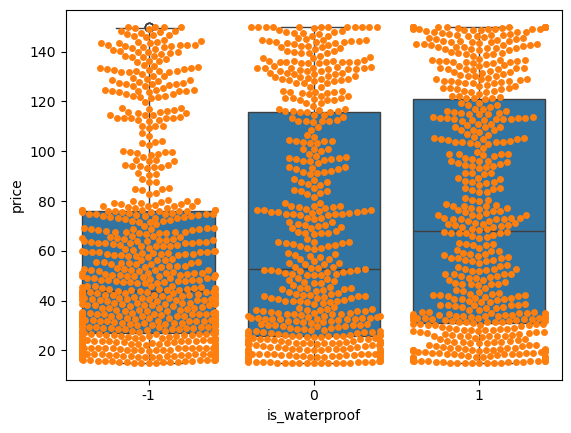

In [42]:
sns.boxplot(no_weight, y='price', x='is_waterproof')
sns.swarmplot(no_weight, y='price', x='is_waterproof')

In [40]:
no_weight = train_df[train_df.weight_capacity_int == 0]

for col in ['brand', 'material', 'size', 'compartments', 'laptop_compartment',
           'is_waterproof', 'style', 'color', 'weight_capacity', 'price',
            'size_int']:
    display(no_weight.groupby(col,as_index=False)['price'].mean())
    

,brand,price
0,Adidas,58.294825
1,Jansport,59.370118
2,Nike,54.095322
3,Puma,54.336706
4,Under Armour,61.310101


,material,price
0,Canvas,61.748021
1,Leather,59.223690
2,Nylon,62.749573
3,Polyester,68.009253


,size,price
0,Large,65.034564
1,Medium,64.695639
2,Small,65.756096


,compartments,price
0,1.0,64.317021
1,2.0,62.492984
2,3.0,55.631118
3,4.0,56.420469
4,5.0,63.036069
5,6.0,72.597326
6,7.0,74.886979
7,8.0,77.958458
8,9.0,78.012127
9,10.0,78.108136


,laptop_compartment,price
0,-1,73.591351
1,0,59.698449
2,1,65.479482


,is_waterproof,price
0,-1,57.933388
1,0,68.102424
2,1,74.776023


,style,price
0,Backpack,66.283390
1,Messenger,67.781519
2,Tote,65.788673


,color,price
0,Black,64.463165
1,Blue,71.786784
2,Gray,64.773535
3,Green,62.674772
4,Pink,61.804820
5,Red,65.480462


,weight_capacity,price
0,0.0,66.03232


,price
0,15.00000
1,15.02470
2,15.05360
3,15.10386
4,15.12481
...,...
1689,149.70284
1690,149.75299
1691,149.76168
1692,149.87054


,size_int,price
0,0,69.017116
1,1,65.756096
2,2,64.695639
3,3,65.034564


<Axes: xlabel='price', ylabel='Count'>

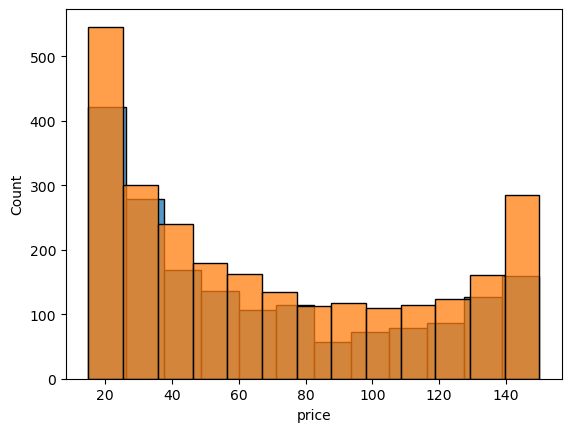

In [31]:
# train_df[train_df.weight_capacity_int.isna()]
sns.histplot(train_df[train_df.weight_capacity_int == 0]['price'])
sns.histplot(train_df[train_df.weight_capacity_int == 30]['price'])

<Axes: xlabel='price', ylabel='Count'>

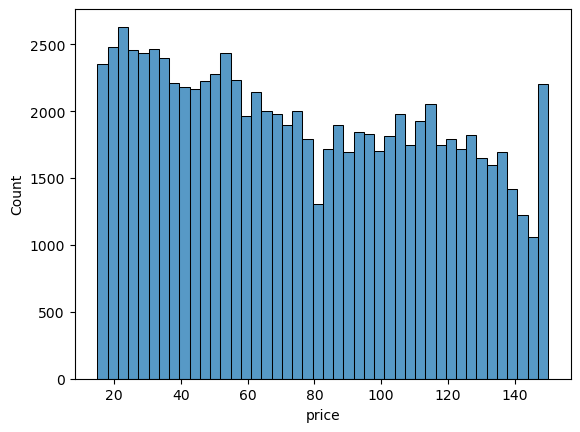

In [33]:
sns.histplot(train_df[train_df.weight_capacity_int == 5]['price'])

<Axes: xlabel='price', ylabel='Count'>

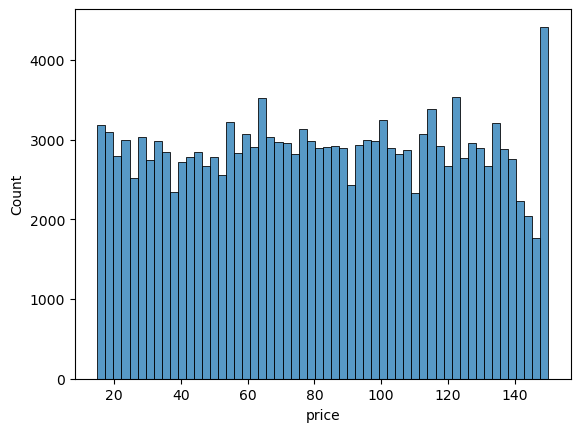

In [32]:
sns.histplot(train_df[train_df.weight_capacity_int == 16]['price'])

In [25]:
train_df.groupby(['weight_capacity_int'], dropna=False, as_index=False)['price'].agg(['mean', 'count']).sort_values(by='count')

,weight_capacity_int,mean,count
0,0,66.032320,1808
26,30,70.344396,2588
1,5,76.946368,86153
25,29,81.417950,126100
3,7,80.063545,142245
5,9,79.171325,143392
4,8,79.909649,143549
6,10,80.977386,146722
2,6,79.561431,148191
9,13,81.095947,155443


In [21]:
train_df.groupby(['weight_capacity_int', 'color'], as_index=False)['price'].agg(['mean', 'count']).sort_values(by='count')

,weight_capacity_int,color,mean,count
1,0,Blue,71.786784,203
3,0,Green,62.674772,210
2,0,Gray,64.773535,232
0,0,Black,64.463165,261
157,30,Blue,71.261619,308
...,...,...,...,...
52,12,Pink,81.497379,30773
140,27,Gray,80.924187,30819
82,17,Pink,82.744116,30886
100,20,Pink,81.811194,31065


In [85]:
def preprocess_weight_capacity(train_df, test_df, n_bins=5):
    """
    Function to bin 'weight_capacity' and apply Target Encoding based on the target column.
    
    Parameters:
    train_df (pd.DataFrame): Training dataframe containing 'weight_capacity'.
    test_df (pd.DataFrame): Test dataframe containing 'weight_capacity'.
    target_column (str): Target variable for encoding.
    n_bins (int): Number of bins for discretization.
    
    Returns:
    pd.DataFrame, pd.DataFrame: Transformed train and test DataFrames.
    """
    # Apply KBinsDiscretizer to bin 'weight_capacity'
    bins_discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    train_df['binned_weight_capacity'] = bins_discretizer.fit_transform(train_df[['weight_capacity']])
    test_df['binned_weight_capacity'] = bins_discretizer.transform(test_df[['weight_capacity']])

    # Apply TargetEncoder to encode the binned values based on the target_column
    target_encoder = TargetEncoder(target_type="continuous")
    train_df['encoded_weight_capacity'] = target_encoder.fit_transform(train_df[['binned_weight_capacity']], train_df[target])
    test_df['encoded_weight_capacity'] = target_encoder.transform(test_df[['binned_weight_capacity']])
    
    return train_df, test_df

In [89]:
df = train_df.copy()
bins_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df['binned_weight_capacity'] = bins_discretizer.fit_transform(df[['weight_capacity']])

target_encoder = TargetEncoder()
df['encoded_weight_capacity'] = target_encoder.fit_transform(df[['binned_weight_capacity']], df[target])
df

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,price,size_int,weight_capacity_int,weight_capacity_size,binned_weight_capacity,encoded_weight_capacity
0,Jansport,Leather,Medium,7.0,1,0,Tote,Black,11.611723,112.15875,2,11,23.223446,1.0,81.477060
1,Jansport,Canvas,Small,10.0,1,1,Messenger,Green,27.078537,68.88056,1,27,27.078537,4.0,81.878728
2,Under Armour,Leather,Small,2.0,1,0,Messenger,Red,16.643760,39.17320,1,16,16.643760,2.0,82.182396
3,Nike,Nylon,Small,8.0,1,0,Messenger,Green,12.937220,80.60793,1,12,12.937220,1.0,81.477060
4,Adidas,Canvas,Medium,1.0,1,1,Messenger,Green,17.749338,86.02312,2,17,35.498677,2.0,82.189217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994313,Nike,Canvas,NaN,3.0,1,1,Messenger,Blue,28.098120,104.74460,0,28,0.000000,4.0,81.840607
3994314,Puma,Leather,Small,10.0,1,1,Tote,Blue,17.379531,122.39043,1,17,17.379531,2.0,82.182396
3994315,Jansport,Canvas,Large,10.0,0,0,Backpack,Red,17.037708,148.18470,3,17,51.113124,2.0,82.189217
3994316,Puma,Canvas,NaN,2.0,0,0,Backpack,Gray,28.783339,22.32269,0,28,0.000000,4.0,81.863574


In [90]:
df.groupby('binned_weight_capacity').mean('weight_capacity')

,laptop_compartment,is_waterproof,weight_capacity,price,size_int,weight_capacity_int,weight_capacity_size,encoded_weight_capacity
binned_weight_capacity,,,,,,,,
0.0,0.466075,0.468488,8.157747,79.577652,1.980653,7.626354,16.154446,79.577629
1.0,0.468188,0.467242,13.354291,81.498674,1.969255,12.803882,26.293018,81.498701
2.0,0.474832,0.471856,18.118740,82.197817,1.972133,17.546724,35.740828,82.197782
3.0,0.472611,0.471414,22.859926,81.683447,1.971058,22.264032,45.057550,81.683414
4.0,0.464630,0.467935,27.547885,81.857677,1.977940,26.970671,54.491380,81.857672


In [87]:
def cross_validate_features(models, X, y, kf):
    model_scores = {name: [] for name in models.keys()}
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'verbose': -1,
        'force_row_wise': True
    }

    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        print(f"Starting Fold {fold}...")

        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

        X_train, X_valid = preprocess_weight_capacity(pd.concat([X_train, y_train], axis=1), X_valid)
        
        for name, model_features in models.items():
            
            train_data = lgb.Dataset(X_train[model_features], label=y_train)
            valid_data = lgb.Dataset(X_valid[model_features], label=y_valid, reference=train_data)
            fit_model = lgb.train(params, train_data, num_boost_round=500, valid_sets=[valid_data])
            y_pred = fit_model.predict(X_valid[model_features], num_iteration=fit_model.best_iteration)
            
            rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
            model_scores[name].append(rmse)
            
    return pd.DataFrame(model_scores)

In [88]:
models = {
    "baseline": baseline_features,
    "weight_capacity": ["weight_capacity"],
    "binned_weight_capacity": ["binned_weight_capacity"],
    "encoded_weight_capacity": ["encoded_weight_capacity"],
    "bin / encode weight_capacity": ["binned_weight_capacity", "encoded_weight_capacity"],
    # "color": ["color"],
    # "brand": ["brand"],
    # "compartments": ["compartments"],
    # "material": ["material"],
    # "is_waterproof": ["is_waterproof"],
}

X = train_df.drop(columns=[target])
y = train_df[target]
kf = KFold(n_splits=10, shuffle=True, random_state=42)
result_df = cross_validate_features(models, X, y, kf)
summary_df = pd.DataFrame({
    "Mean RMSE": result_df.mean(),
    "Std RMSE": result_df.std()
})
display(summary_df)

Starting Fold 1...
Starting Fold 2...
Starting Fold 3...
Starting Fold 4...
Starting Fold 5...
Starting Fold 6...
Starting Fold 7...
Starting Fold 8...
Starting Fold 9...
Starting Fold 10...


,Mean RMSE,Std RMSE
baseline,38.890352,0.040699
weight_capacity,38.913651,0.041688
binned_weight_capacity,38.927774,0.042079
encoded_weight_capacity,38.927784,0.042071
bin / encode weight_capacity,38.927784,0.042071
is_waterproof,38.936586,0.042869


In [103]:
from itertools import combinations

def target_encoding(
    train_df: pd.DataFrame,
    cat_cols: list,
    target: str,
    test_df: pd.DataFrame = None,
    interactions: bool = True
):
    # Make copies to avoid mutating original data
    train_df = train_df.copy()
    test_df = test_df.copy() if test_df is not None else None
    
    encoded_cols = []

    # --- Encode each individual categorical column with TargetEncoder ---
    for col in cat_cols:
        # Initialize a fresh TargetEncoder for each column
        te = TargetEncoder(target_type="continuous")  
        
        # Fit on the training data
        # print(train_df[target])
        train_encoded = te.fit_transform(train_df[[col]], train_df[target])
        train_encoded_col = f"{col}_encoded"
        train_df[train_encoded_col] = train_encoded
        
        # Apply to test data (if provided)
        if test_df is not None:
            test_encoded = te.transform(test_df[[col]])
            test_encoded_col = f"{col}_encoded"
            test_df[test_encoded_col] = test_encoded
            
        encoded_cols.append(train_encoded_col)

    # --- (Optional) Encode interaction columns ---
    if interactions:
        for col1, col2 in combinations(cat_cols, 2):
            # Construct an interaction feature in train
            train_interaction = train_df[col1].astype(str) + "_" + train_df[col2].astype(str)
            
            # We'll store it in a temporary column just for clarity
            train_df["_interaction"] = train_interaction
            
            # Fit a fresh TargetEncoder on this new "interaction" column
            te_inter = TargetEncoder(target_type="continuous")
            train_encoded = te_inter.fit_transform(train_df[["_interaction"]], train_df[target])
            
            # Create a column name for the interaction encoding
            interaction_encoded_col = f"{col1}_{col2}_encoded"
            train_df[interaction_encoded_col] = train_encoded
            
            # Encode the test data (if provided)
            if test_df is not None:
                test_interaction = test_df[col1].astype(str) + "_" + test_df[col2].astype(str)
                test_df["_interaction"] = test_interaction
                test_encoded = te_inter.transform(test_df[["_interaction"]])
                test_df[interaction_encoded_col] = test_encoded
                
                # Drop the temporary interaction column
                test_df.drop(columns="_interaction", inplace=True, errors="ignore")

            # Drop the temporary interaction column from train
            train_df.drop(columns="_interaction", inplace=True, errors="ignore")

            encoded_cols.append(interaction_encoded_col)

    return train_df, test_df, encoded_cols

In [ ]:
cat_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist() + ['laptop_compartment', 'is_waterproof', 'weight_capacity_int']
train_df_encoded, _, encoded_cols = target_encoding(
    train_df=train_df, 
    cat_cols=cat_cols, 
    target=target, 
    test_df=train_df
)
train_df_encoded

In [101]:
encoded_cols

['brand_encoded',
 'material_encoded',
 'size_encoded',
 'compartments_encoded',
 'style_encoded',
 'color_encoded',
 'laptop_compartment_encoded',
 'is_waterproof_encoded',
 'weight_capacity_int_encoded',
 'brand_material_encoded',
 'brand_size_encoded',
 'brand_compartments_encoded',
 'brand_style_encoded',
 'brand_color_encoded',
 'brand_laptop_compartment_encoded',
 'brand_is_waterproof_encoded',
 'brand_weight_capacity_int_encoded',
 'material_size_encoded',
 'material_compartments_encoded',
 'material_style_encoded',
 'material_color_encoded',
 'material_laptop_compartment_encoded',
 'material_is_waterproof_encoded',
 'material_weight_capacity_int_encoded',
 'size_compartments_encoded',
 'size_style_encoded',
 'size_color_encoded',
 'size_laptop_compartment_encoded',
 'size_is_waterproof_encoded',
 'size_weight_capacity_int_encoded',
 'compartments_style_encoded',
 'compartments_color_encoded',
 'compartments_laptop_compartment_encoded',
 'compartments_is_waterproof_encoded',
 'c

In [113]:
def cross_validate_encoded_features(models, X, y, kf):
    model_scores = {name: [] for name in models.keys()}
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'verbose': -1,
        'force_row_wise': True
    }

    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        print(f"Starting Fold {fold}...")

        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

        X_train, X_valid = preprocess_weight_capacity(pd.concat([X_train, y_train], axis=1), X_valid)

        X_train, X_valid, encoded_cols = target_encoding(
            train_df=X_train,
            cat_cols=cat_cols,
            test_df=X_valid, 
            target=y_train.name,
        )
        
        for name, model_features in models.items():
            
            train_data = lgb.Dataset(X_train[model_features], label=y_train)
            valid_data = lgb.Dataset(X_valid[model_features], label=y_valid, reference=train_data)
            fit_model = lgb.train(params, train_data, num_boost_round=500, valid_sets=[valid_data])
            y_pred = fit_model.predict(X_valid[model_features], num_iteration=fit_model.best_iteration)
            
            rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
            model_scores[name].append(rmse)
            
    return pd.DataFrame(model_scores)

In [114]:
models = {
    "baseline": baseline_features,
    "encoded_cols": encoded_cols,
    "encoded_cols + baseline": encoded_cols + baseline_features,
    "weight_capacity": ["weight_capacity"],
    "weight_capacity_int": ["weight_capacity_int"],
}

X = train_df.drop(columns=[target])
y = train_df[target]
kf = KFold(n_splits=10, shuffle=True, random_state=42)
result_df = cross_validate_encoded_features(models, X, y, kf)
summary_df = pd.DataFrame({
    "Mean RMSE": result_df.mean(),
    "Std RMSE": result_df.std()
})
display(summary_df)

Starting Fold 1...
Starting Fold 2...
Starting Fold 3...
Starting Fold 4...
Starting Fold 5...
Starting Fold 6...
Starting Fold 7...
Starting Fold 8...
Starting Fold 9...
Starting Fold 10...


,Mean RMSE,Std RMSE
baseline,38.890352,0.040699
encoded_cols,38.878400,0.040960
encoded_cols + baseline,38.871738,0.041062
weight_capacity,38.913651,0.041688
weight_capacity_int,38.919285,0.041895


In [111]:
def cross_validate_encoded_features_xgb(models, X, y, kf):
    model_scores = {name: [] for name in models.keys()}
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        'learning_rate': 0.1,
        'feature_fraction': 0.9,
        'verbose': -1,
        'device': "cuda",
        'force_row_wise': True,
        'subsample': 0.85,
        'colsample_bylevel': 0.9,
        'colsample_bytree': 0.9,
        'gamma': 0.6,
        'max_depth': 6, 
        'min_child_weight': 2,
        'reg_alpha': 1.0, 
        'reg_lambda': 1e-06
    }

    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        print(f"Starting Fold {fold}...")

        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

        X_train, X_valid = preprocess_weight_capacity(pd.concat([X_train, y_train], axis=1), X_valid)

        X_train, X_valid, encoded_cols = target_encoding(
            train_df=X_train,
            cat_cols=cat_cols,
            test_df=X_valid, 
            target=y_train.name,
        )
        
        for name, model_features in models.items():

            dtrain = xgb.DMatrix(X_train[model_features], label=y_train, enable_categorical=True)
            dvalid = xgb.DMatrix(X_valid[model_features], label=y_valid, enable_categorical=True)

            bst = xgb.train(
                params=params,
                dtrain=dtrain,
                num_boost_round=1000,
                evals=[(dtrain, "train"), (dvalid, "validation_0")],
                early_stopping_rounds=50,
                verbose_eval=False,
            )
            y_pred = bst.predict(dvalid)
            
            rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
            model_scores[name].append(rmse)
            
    return pd.DataFrame(model_scores)

In [112]:
models = {
    "baseline": baseline_features,
    "encoded_cols": encoded_cols,
    "encoded_cols + baseline": encoded_cols + baseline_features,
    "weight_capacity": ["weight_capacity"],
    "weight_capacity_int": ["weight_capacity_int"],
}

X = train_df.drop(columns=[target])
y = train_df[target]
kf = KFold(n_splits=10, shuffle=True, random_state=42)
result_df = cross_validate_encoded_features_xgb(models, X, y, kf)
summary_df = pd.DataFrame({
    "Mean RMSE": result_df.mean(),
    "Std RMSE": result_df.std()
})
display(summary_df)

Starting Fold 1...
Starting Fold 2...
Starting Fold 3...
Starting Fold 4...
Starting Fold 5...
Starting Fold 6...
Starting Fold 7...
Starting Fold 8...
Starting Fold 9...
Starting Fold 10...


,Mean RMSE,Std RMSE
baseline,38.889410,0.041246
encoded_cols,38.880539,0.040766
encoded_cols + baseline,38.873157,0.040084
weight_capacity,38.911797,0.041774
weight_capacity_int,38.919288,0.041894


In [80]:
train_df['weight_capacity_int'] = train_df['weight_capacity'].astype(int)
train_df['weight_capacity_size'] = train_df['weight_capacity'] * train_df['size_int']

train_df['weight_capacity_binned'] = pd.qcut(train_df['weight_capacity'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Interaction Terms
train_df['weight_capacity_brand'] = train_df['weight_capacity'] * train_df['brand'].astype('category').cat.codes

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
train_df[['weight_capacity_poly_2']] = poly.fit_transform(train_df[['weight_capacity']])[:, 1:2]  # squared term
train_df[['weight_capacity_poly_3']] = poly.transform(train_df[['weight_capacity']])[:, 2:]

# Exponential
train_df['weight_capacity_exp'] = np.exp(train_df['weight_capacity'])

# Reciprocal Transformations
train_df['weight_capacity_inv'] = 1 / (train_df['weight_capacity'] + 1e-6)  # Avoid division by zero

# Principal Component Analysis (PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
train_df['weight_capacity_pca'] = pca.fit_transform(train_df[['weight_capacity']])
# train_df['weight_capacity_pca2'] = pca.fit_transform(train_df[['weight_capacity', 'color', 'compartments', 'brand']])

In [76]:

features_to_try = [
    'weight_capacity_int', 'weight_capacity_size', 
    'weight_capacity_binned', 'weight_capacity_brand', 'weight_capacity_poly_2', 
    'weight_capacity_poly_3','weight_capacity_exp', 'weight_capacity_inv', 
    'weight_capacity_pca'] # , 'weight_capacity_density'

models = {
    "baseline": baseline_features,
    "weight_capacity_int": ['weight_capacity_int'] + baseline_features,
    "weight_capacity_size": ['weight_capacity_size'] + baseline_features,
    "weight_capacity_binned": ['weight_capacity_binned'] + baseline_features,
    "weight_capacity_brand": ['weight_capacity_brand'] + baseline_features,
    "weight_capacity_poly_2": ['weight_capacity_poly_2'] + baseline_features,
    "weight_capacity_poly_3": ['weight_capacity_poly_3'] + baseline_features,
    "weight_capacity_exp": ['weight_capacity_exp'] + baseline_features,
    "weight_capacity_inv": ['weight_capacity_inv'] + baseline_features,
    # "weight_capacity_density": ['weight_capacity_density'] + baseline_features,
    "weight_capacity_pca": ['weight_capacity_pca'] + baseline_features,
    
    # Combination models
    "poly_features": ['weight_capacity_poly_2', 'weight_capacity_poly_3'] + baseline_features,
    "transformed_features": ['weight_capacity_exp', 'weight_capacity_inv'] + baseline_features,
    "interaction_features": ['weight_capacity_brand', 'weight_capacity_size'] + baseline_features,
    # "density_pca_features": ['weight_capacity_density', 'weight_capacity_pca', 'weight_capacity'] + baseline_features,
    "all_features": features_to_try + baseline_features  # Full model
}

In [ ]:
X = train_df.drop(columns=[target])
y = train_df[target]
kf = KFold(n_splits=10, shuffle=True, random_state=42)
result_df = cross_validate_features(models, X, y, kf, verbose=False)
summary_df = pd.DataFrame({
    "Mean RMSE": result_df.mean(),
    "Std RMSE": result_df.std()
})
display(summary_df)

In [20]:
from itertools import combinations

def mean_std_target_encoding(df, cat_cols, target, interactions=True):
    df = df.copy()  # Avoid modifying the original dataframe
    encoded_cols = []  # Store new encoded column names
    
    for col in cat_cols:
        # Compute mean and std of target for each category in the column
        category_stats = df.groupby(col)[target].agg(['mean', 'std'])
        
        # Map the values to the dataframe
        df[f'{col}_mean'] = df[col].map(category_stats['mean']).astype(float)
        df[f'{col}_std'] = df[col].map(category_stats['std']).astype(float)
        
        encoded_cols.extend([f'{col}_mean', f'{col}_std'])
        
        # Fill NaN values (in case some categories are missing)
        df[f'{col}_mean'].fillna(df[f'{col}_mean'].mean(), inplace=True)
        df[f'{col}_std'].fillna(df[f'{col}_std'].mean(), inplace=True)
    
    if interactions:
        # Interaction Target Encoding
        for col1, col2 in combinations(cat_cols, 2):
            interaction_col = df[col1].astype(str) + "_" + df[col2].astype(str)
            
            # Compute mean and std of target for each interaction category
            interaction_stats = df.groupby(interaction_col)[target].agg(['mean', 'std'])
            
            # Map the values to the dataframe
            df[f'{col1}_{col2}_mean'] = interaction_col.map(interaction_stats['mean']).astype(float)
            df[f'{col1}_{col2}_std'] = interaction_col.map(interaction_stats['std']).astype(float)
            
            encoded_cols.extend([f'{col1}_{col2}_mean', f'{col1}_{col2}_std'])
            
            # Fill NaN values (in case some interactions are missing)
            df[f'{col1}_{col2}_mean'].fillna(df[f'{col1}_{col2}_mean'].mean(), inplace=True)
            df[f'{col1}_{col2}_std'].fillna(df[f'{col1}_{col2}_std'].mean(), inplace=True)
    
    return df, encoded_cols

In [50]:
from itertools import combinations
import pandas as pd

def mean_std_target_encoding(
    train_df: pd.DataFrame,
    cat_cols: list,
    target: str,
    test_df: pd.DataFrame = None,
    interactions: bool = True
):
    """
    Computes mean and std of the target for each categorical feature (and optional interactions)
    from train_df, then maps those statistics onto both train_df and test_df if provided.

    Parameters
    ----------
    train_df : pd.DataFrame
        The training dataframe.
    cat_cols : list
        List of categorical columns to encode.
    target : str
        The target column name on which to compute mean and std.
    test_df : pd.DataFrame, optional
        The test dataframe. If provided, the train statistics are applied to it.
    interactions : bool, optional
        Whether to create interaction columns for every pair of `cat_cols`.

    Returns
    -------
    train_df : pd.DataFrame
        The modified training dataframe with new encoding columns.
    test_df : pd.DataFrame or None
        The modified test dataframe if provided; otherwise None.
    encoded_cols : list
        List of newly created encoded column names.
    """
    
    # Make copies to avoid mutating original data
    train_df = train_df.copy()
    test_df = test_df.copy() if test_df is not None else None
    
    encoded_cols = []

    # --- Encode each individual categorical column ---
    for col in cat_cols:
        # 1) Compute stats on train
        category_stats = train_df.groupby(col)[target].agg(['mean', 'std'])
        
        # 2) Map to train
        mean_col_name = f'{col}_mean'
        std_col_name  = f'{col}_std'
        
        train_df[mean_col_name] = train_df[col].map(category_stats['mean']).astype(float)
        train_df[std_col_name]  = train_df[col].map(category_stats['std']).astype(float)
        
        # 3) Compute the train-level means (for filling missing values)
        train_mean_for_mean = train_df[mean_col_name].mean()
        train_mean_for_std  = train_df[std_col_name].mean()
        
        # Fill any missing in train itself
        train_df[mean_col_name].fillna(train_mean_for_mean, inplace=True)
        train_df[std_col_name].fillna(train_mean_for_std, inplace=True)
        
        # 4) If a test_df is provided, apply same mapping
        if test_df is not None:
            test_df[mean_col_name] = test_df[col].map(category_stats['mean']).astype(float)
            test_df[std_col_name]  = test_df[col].map(category_stats['std']).astype(float)
            test_df[mean_col_name].fillna(train_mean_for_mean, inplace=True)
            test_df[std_col_name].fillna(train_mean_for_std, inplace=True)

        encoded_cols.extend([mean_col_name, std_col_name])

    # --- (Optional) Encode interaction columns ---
    if interactions:
        for col1, col2 in combinations(cat_cols, 2):
            # Construct an interaction column in train
            train_interaction = train_df[col1].astype(str) + "_" + train_df[col2].astype(str)
            
            # Compute stats on train using the interaction
            interaction_stats = train_df.groupby(train_interaction)[target].agg(['mean', 'std'])
            
            # Column names for the new features
            mean_col_name = f'{col1}_{col2}_mean'
            std_col_name  = f'{col1}_{col2}_std'
            
            # Map onto the train
            train_df[mean_col_name] = train_interaction.map(interaction_stats['mean']).astype(float)
            train_df[std_col_name]  = train_interaction.map(interaction_stats['std']).astype(float)
            
            # Compute the train-level means for missing values
            train_mean_for_mean = train_df[mean_col_name].mean()
            train_mean_for_std  = train_df[std_col_name].mean()
            
            # Fill missing in train
            train_df[mean_col_name].fillna(train_mean_for_mean, inplace=True)
            train_df[std_col_name].fillna(train_mean_for_std, inplace=True)
            
            # If test_df provided, apply same logic
            if test_df is not None:
                test_interaction = test_df[col1].astype(str) + "_" + test_df[col2].astype(str)
                test_df[mean_col_name] = test_interaction.map(interaction_stats['mean']).astype(float)
                test_df[std_col_name]  = test_interaction.map(interaction_stats['std']).astype(float)
                test_df[mean_col_name].fillna(train_mean_for_mean, inplace=True)
                test_df[std_col_name].fillna(train_mean_for_std, inplace=True)
                

            encoded_cols.extend([mean_col_name, std_col_name])

    return train_df, test_df, encoded_cols


In [51]:
# df = train_df.copy()  # Avoid modifying the original dataframe
# encoded_cols = []  # Store new encoded column names

# for col in cat_cols:
#     # Compute mean and std of target for each category in the column
#     category_stats = df.groupby(col)[target].agg(['mean', 'std'])
    
#     # Map the values to the dataframe
#     df[f'{col}_mean'] = df[col].map(category_stats['mean']).astype(float)
#     df[f'{col}_std'] = df[col].map(category_stats['std']).astype(float)
    
#     encoded_cols.extend([f'{col}_mean', f'{col}_std'])
#     break
    
#     # Fill NaN values (in case some categories are missing)
#     df[f'{col}_mean'].fillna(df[f'{col}_mean'].mean(), inplace=True)
#     df[f'{col}_std'].fillna(df[f'{col}_std'].mean(), inplace=True)

# df[encoded_cols].info()

In [52]:
cat_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist() + ['laptop_compartment', 'is_waterproof']
train_df_encoded, _, encoded_cols = mean_std_target_encoding(
    train_df, 
    cat_cols=cat_cols, 
    target=target, 
    test_df=train_df
)

In [40]:
X.select_dtypes(include=['object', 'category']).columns.tolist() + ['laptop_compartment', 'is_waterproof']

['brand',
 'material',
 'size',
 'compartments',
 'style',
 'color',
 'laptop_compartment',
 'is_waterproof']

In [58]:
def cross_validate_features(models, X, y, kf, verbose=True):
    model_scores = {name: [] for name in models.keys()}
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        # 'num_leaves': 310,
        # 'learning_rate': 0.1,
        # 'feature_fraction': 0.9,
        'verbose': -1,
        'force_row_wise': True
    }

    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist() + ['laptop_compartment', 'is_waterproof']

    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        # if verbose:
        print(f"Starting Fold {fold}...")
        fold_start_time = time.time()

        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

        X_train, X_valid, encoded_cols = mean_std_target_encoding(
            train_df=pd.concat([X_train, y_train], axis=1),
            cat_cols=cat_cols,
            test_df=pd.concat([X_valid, y_valid], axis=1), 
            target=y_train.name,
        )
        
        for name, model_features in models.items():
            model_start_time = time.time()
            
            train_data = lgb.Dataset(X_train[model_features], label=y_train)
            valid_data = lgb.Dataset(X_valid[model_features], label=y_valid, reference=train_data)
            fit_model = lgb.train(params, train_data, num_boost_round=500, valid_sets=[valid_data])
            y_pred = fit_model.predict(X_valid[model_features], num_iteration=fit_model.best_iteration)
            
            rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
            model_scores[name].append(rmse)
            
            if verbose:
                print(f"{name} Model - Fold {fold} - Training & Prediction time: {time.time() - model_start_time:.2f} seconds")

        if verbose:
            print(f"Total time for Fold {fold}: {time.time() - fold_start_time:.2f} seconds")
            print("-" * 50)

    return pd.DataFrame(model_scores)

In [59]:
models = {
    "baseline": baseline_features,
    "encoded_cols": encoded_cols,
    "all": encoded_cols + baseline_features,
}

X = train_df.drop(columns=[target])
y = train_df[target]
kf = KFold(n_splits=10, shuffle=True, random_state=42)
result_df = cross_validate_features(models, X, y, kf, verbose=False)
summary_df = pd.DataFrame({
    "Mean RMSE": result_df.mean(),
    "Std RMSE": result_df.std()
})
display(summary_df)

Starting Fold 1...
Starting Fold 2...
Starting Fold 3...
Starting Fold 4...
Starting Fold 5...
Starting Fold 6...
Starting Fold 7...
Starting Fold 8...
Starting Fold 9...
Starting Fold 10...


,Mean RMSE,Std RMSE
baseline,39.098039,0.071875
encoded_cols,39.181230,0.062547
all,39.130446,0.066703


In [57]:
models = {
    "baseline": baseline_features,
    "encoded_cols": encoded_cols,
    "all": encoded_cols + baseline_features,
}

X = train_df.drop(columns=[target])
y = train_df[target]
kf = KFold(n_splits=10, shuffle=True, random_state=42)
result_df = cross_validate_features(models, X, y, kf, verbose=False)
summary_df = pd.DataFrame({
    "Mean RMSE": result_df.mean(),
    "Std RMSE": result_df.std()
})
display(summary_df)

,Mean RMSE,Std RMSE
baseline,39.712155,0.078255
encoded_cols,40.583526,0.055446
all,40.058195,0.084779


In [8]:
# def mean_std_target_encoding(df, cat_cols, target_col):
#     df = df.copy()  # Avoid modifying the original dataframe
#     encoded_cols = []  # Store new encoded column names
    
#     for col in cat_cols:
#         # Compute mean and std of target for each category in the column
#         category_stats = df.groupby(col)[target_col].agg(['mean', 'std'])
        
#         # Map the values to the dataframe
#         df[f'{col}_mean'] = df[col].map(category_stats['mean'])
#         df[f'{col}_std'] = df[col].map(category_stats['std'])
        
#         encoded_cols.extend([f'{col}_mean', f'{col}_std'])
        
#         # Fill NaN values (in case some categories are missing)
#         df[f'{col}_mean'].fillna(df[f'{col}_mean'].mean(), inplace=True)
#         df[f'{col}_std'].fillna(df[f'{col}_std'].mean(), inplace=True)
    
#     return df, encoded_cols


In [5]:
cat_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist() + ['laptop_compartment', 'is_waterproof']

In [6]:
for col1, col2 in combinations(cat_cols, 2):
    print(col1, col2)

brand material
brand size
brand compartments
brand style
brand color
brand laptop_compartment
brand is_waterproof
material size
material compartments
material style
material color
material laptop_compartment
material is_waterproof
size compartments
size style
size color
size laptop_compartment
size is_waterproof
compartments style
compartments color
compartments laptop_compartment
compartments is_waterproof
style color
style laptop_compartment
style is_waterproof
color laptop_compartment
color is_waterproof
laptop_compartment is_waterproof


In [72]:
# Loop over each categorical column and map each category to the mean target value
for col in cat_cols:
    # Compute the mean target for each category in the column
    category_target_mean = train_df.groupby(col)[target].mean()
    train_df[f'{col}_mean'] = train_df[col].map(category_target_mean)

cat_mean_cols = [f'{col}_mean' for col in cat_cols]

In [4]:
train_df.select_dtypes(include=['object', 'category']).columns.tolist() + ['laptop_compartment', 'is_waterproof']

['brand',
 'material',
 'size',
 'compartments',
 'style',
 'color',
 'laptop_compartment',
 'is_waterproof']

In [74]:
cat_mean_cols

['brand_mean',
 'material_mean',
 'size_mean',
 'compartments_mean',
 'style_mean',
 'color_mean',
 'laptop_compartment_mean',
 'is_waterproof_mean']

In [ ]:
train_df.columns

Index(['id', 'Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price'],
      dtype='object')

In [81]:
train_df.columns

Index(['brand', 'material', 'size', 'compartments', 'laptop_compartment',
       'is_waterproof', 'style', 'color', 'weight_capacity', 'price',
       'size_int', 'weight_capacity_int', 'weight_capacity_size', 'brand_mean',
       'material_mean', 'size_mean', 'compartments_mean', 'style_mean',
       'color_mean', 'laptop_compartment_mean', 'is_waterproof_mean',
       'weight_capacity_binned', 'weight_capacity_brand',
       'weight_capacity_poly_2', 'weight_capacity_poly_3',
       'weight_capacity_exp', 'weight_capacity_inv', 'weight_capacity_pca'],
      dtype='object')

In [84]:
models = {
    "baseline": baseline_features,
    "cat_mean_cols": cat_mean_cols,
    "cat_mean_cols + ": cat_mean_cols + baseline_features,
    "all_features +":  features_to_try + baseline_features,
    "all_features ++":  cat_mean_cols + features_to_try + baseline_features
}

X = train_df.drop(columns=[target])
y = train_df[target]
kf = KFold(n_splits=10, shuffle=True, random_state=42)
result_df = cross_validate_features(models, X, y, kf, verbose=False)
summary_df = pd.DataFrame({
    "Mean RMSE": result_df.mean(),
    "Std RMSE": result_df.std()
})
display(summary_df)

,Mean RMSE,Std RMSE
baseline,39.037680,0.063194
cat_mean_cols,39.057084,0.067168
cat_mean_cols +,39.033518,0.064217
all_features +,39.040334,0.062872
all_features ++,39.036105,0.065110


In [85]:
train_df

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,price,...,color_mean,laptop_compartment_mean,is_waterproof_mean,weight_capacity_binned,weight_capacity_brand,weight_capacity_poly_2,weight_capacity_poly_3,weight_capacity_exp,weight_capacity_inv,weight_capacity_pca
0,Jansport,Leather,Medium,7.0,1,0,Tote,Black,11.611723,112.15875,...,80.513439,81.463842,81.572050,Low,11.611723,134.832107,1565.633046,1.103843e+05,0.086120,6.409977
1,Jansport,Canvas,Small,10.0,1,1,Messenger,Green,27.078537,68.88056,...,82.381308,81.463842,81.403489,Very High,27.078537,733.247143,19855.259594,5.755181e+11,0.036930,-9.056836
2,Under Armour,Leather,Small,2.0,1,0,Messenger,Red,16.643760,39.17320,...,81.011644,81.463842,81.572050,Medium,66.575040,277.014745,4610.566922,1.691582e+07,0.060083,1.377940
3,Nike,Nylon,Small,8.0,1,0,Messenger,Green,12.937220,80.60793,...,82.381308,81.463842,81.572050,Medium,25.874441,167.371669,2165.324158,4.154927e+05,0.077296,5.084480
4,Adidas,Canvas,Medium,1.0,1,1,Messenger,Green,17.749338,86.02312,...,82.381308,81.463842,81.403489,Medium,0.000000,315.039016,5591.734125,5.110222e+07,0.056340,0.272362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,Adidas,Leather,Small,9.0,0,0,Tote,Blue,12.730812,129.99749,...,82.006994,81.464702,81.572050,Medium,0.000000,162.073567,2063.328072,3.380036e+05,0.078550,5.290888
299996,Jansport,Leather,Large,6.0,0,1,Tote,Blue,26.633182,19.85819,...,82.006994,81.464702,81.403489,Very High,26.633182,709.326396,18891.619165,3.686753e+11,0.037547,-8.611482
299997,Puma,Canvas,Large,9.0,1,1,Backpack,Pink,11.898250,111.41364,...,81.630864,81.463842,81.403489,Low,35.694749,141.568346,1684.415531,1.470091e+05,0.084046,6.123450
299998,Adidas,Nylon,Small,1.0,0,1,Tote,Pink,6.175738,115.89080,...,81.630864,81.464702,81.403489,Low,0.000000,38.139739,235.541029,4.809378e+02,0.161924,11.845962


In [131]:
def cross_validate_lightgbm_feature_importances(
    params, X, y, kf, num_boost_round=100
):
    # Prepare a DataFrame to store feature importances for each fold
    # feature_importance_df = pd.DataFrame(
    #     np.zeros((X.shape[1], kf.get_n_splits())),
    #     index=X.columns
    # )
    fold_importances = {}
    scores = []

    for fold_idx, (train_index, test_index) in enumerate(kf.split(X), 1):
        print(f"Starting Fold {fold_idx}...")

        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

        X_train, X_valid = preprocess_weight_capacity(pd.concat([X_train, y_train], axis=1), X_valid)

        X_train, X_valid, encoded_cols = target_encoding(
            train_df=X_train,
            cat_cols=cat_cols,
            test_df=X_valid, 
            target=y_train.name,
        )
        X_train = X_train.drop(columns=[target])

        # Prepare LightGBM datasets
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

        # Train the model
        fit_model = lgb.train(
            params,
            train_data,
            num_boost_round=num_boost_round,
            valid_sets=[valid_data],
        )

        # Predict
        y_pred = fit_model.predict(X_valid, num_iteration=fit_model.best_iteration)
        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
        scores.append(rmse)

        # Store feature importances
        # fold_importances = fit_model.feature_importance(importance_type='gain')
        # feature_importance_df.iloc[:, fold_idx - 1] = fold_importances
        fold_importance_series = pd.Series(
            fit_model.feature_importance(importance_type='gain'),
            index=X_train.columns
        )
        fold_importances[f'fold_{fold_idx}'] = fold_importance_series

    feature_importance_df = pd.DataFrame(fold_importances).fillna(0)

    # Compute the mean importance across folds
    feature_importance_df['mean_importance'] = feature_importance_df.mean(axis=1)
    feature_importance_df.sort_values('mean_importance', ascending=False, inplace=True)
    
    # Compute average feature importance across folds
    # feature_importance_df['mean_importance'] = feature_importance_df.mean(axis=1)
    # feature_importance_df.sort_values('mean_importance', ascending=False, inplace=True)

    return scores, feature_importance_df

In [132]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
lightgbm_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.95,
    'verbose': -1,
    'force_row_wise': True
}

# scores, feature_importances = cross_validate_lightgbm_feature_importances(lightgbm_params, X, y, kf)
# feature_importances.sort_values('mean_importance', ascending=False, inplace=True)
# feature_importances.head(20)  # top 20 most important features

In [133]:
X = train_df.drop(columns=[target])
y = train_df[target]

scores, feature_importances = cross_validate_lightgbm_feature_importances(
    lightgbm_params, X, y, kf
)
display(feature_importances[['mean_importance']])
print("Average RMSE across folds:", np.mean(scores))

Starting Fold 1...
Starting Fold 2...
Starting Fold 3...
Starting Fold 4...
Starting Fold 5...
Starting Fold 6...
Starting Fold 7...
Starting Fold 8...
Starting Fold 9...
Starting Fold 10...


,mean_importance
material_weight_capacity_int_encoded,1.103780e+07
brand_weight_capacity_int_encoded,1.065070e+07
color_weight_capacity_int_encoded,8.826507e+06
size_weight_capacity_int_encoded,7.269190e+06
is_waterproof_weight_capacity_int_encoded,7.231504e+06
weight_capacity,7.198871e+06
material_color_encoded,6.622816e+06
compartments,6.490143e+06
size_compartments_encoded,5.158973e+06
brand_size_encoded,5.057936e+06


Average RMSE across folds: 38.87266071931904


In [137]:
temp = feature_importances[['mean_importance']]
temp

,mean_importance
material_weight_capacity_int_encoded,1.103780e+07
brand_weight_capacity_int_encoded,1.065070e+07
color_weight_capacity_int_encoded,8.826507e+06
size_weight_capacity_int_encoded,7.269190e+06
is_waterproof_weight_capacity_int_encoded,7.231504e+06
weight_capacity,7.198871e+06
material_color_encoded,6.622816e+06
compartments,6.490143e+06
size_compartments_encoded,5.158973e+06
brand_size_encoded,5.057936e+06


In [135]:
feature_importances.index

Index(['material_weight_capacity_int_encoded',
       'brand_weight_capacity_int_encoded',
       'color_weight_capacity_int_encoded', 'size_weight_capacity_int_encoded',
       'is_waterproof_weight_capacity_int_encoded', 'weight_capacity',
       'material_color_encoded', 'compartments', 'size_compartments_encoded',
       'brand_size_encoded', 'compartments_weight_capacity_int_encoded',
       'brand_color_encoded', 'size_is_waterproof_encoded',
       'laptop_compartment_is_waterproof_encoded',
       'size_laptop_compartment_encoded', 'brand_material_encoded',
       'compartments_is_waterproof_encoded', 'size_color_encoded',
       'material_size_encoded', 'style_is_waterproof_encoded',
       'brand_style_encoded', 'style_laptop_compartment_encoded',
       'compartments_laptop_compartment_encoded', 'compartments_color_encoded',
       'material_compartments_encoded', 'brand_compartments_encoded',
       'material_is_waterproof_encoded', 'compartments_style_encoded',
       'sty

In [54]:
X

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,size_int,weight_capacity_int,weight_capacity_size,weight_capacity_binned,weight_capacity_brand,weight_capacity_poly_2,weight_capacity_poly_3,weight_capacity_exp,weight_capacity_inv,weight_capacity_pca
0,Jansport,Leather,Medium,7.0,1,0,Tote,Black,11.611723,2,11,23.223446,Low,11.611723,134.832107,1565.633046,1.103843e+05,0.086120,6.409977
1,Jansport,Canvas,Small,10.0,1,1,Messenger,Green,27.078537,1,27,27.078537,Very High,27.078537,733.247143,19855.259594,5.755181e+11,0.036930,-9.056836
2,Under Armour,Leather,Small,2.0,1,0,Messenger,Red,16.643760,1,16,16.643760,Medium,66.575040,277.014745,4610.566922,1.691582e+07,0.060083,1.377940
3,Nike,Nylon,Small,8.0,1,0,Messenger,Green,12.937220,1,12,12.937220,Medium,25.874441,167.371669,2165.324158,4.154927e+05,0.077296,5.084480
4,Adidas,Canvas,Medium,1.0,1,1,Messenger,Green,17.749338,2,17,35.498677,Medium,0.000000,315.039016,5591.734125,5.110222e+07,0.056340,0.272362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,Adidas,Leather,Small,9.0,0,0,Tote,Blue,12.730812,1,12,12.730812,Medium,0.000000,162.073567,2063.328072,3.380036e+05,0.078550,5.290888
299996,Jansport,Leather,Large,6.0,0,1,Tote,Blue,26.633182,3,26,79.899547,Very High,26.633182,709.326396,18891.619165,3.686753e+11,0.037547,-8.611482
299997,Puma,Canvas,Large,9.0,1,1,Backpack,Pink,11.898250,3,11,35.694749,Low,35.694749,141.568346,1684.415531,1.470091e+05,0.084046,6.123450
299998,Adidas,Nylon,Small,1.0,0,1,Tote,Pink,6.175738,1,6,6.175738,Low,0.000000,38.139739,235.541029,4.809378e+02,0.161924,11.845962


In [10]:
X.columns

Index(['product_id', 'brand', 'material', 'size', 'num_compartments',
       'laptop_compartment', 'is_waterproof', 'style', 'color',
       'weight_capacity_kg'],
      dtype='object')

In [33]:
scores, feature_importances = cross_validate_lightgbm_feature_importances(
    lightgbm_params, 
    X, 
    y, kf, verbose=False
)
display(feature_importances[['mean_importance']])
print("Average RMSE across folds:", np.mean(scores))

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,mean_importance
weight_capacity_kg,4.717618e+07,4.721959e+07,4.678176e+07,4.736137e+07,4.817562e+07,4.779043e+07,4.783330e+07,4.594700e+07,4.658806e+07,4.652244e+07,...,4.584865e+07,4.819638e+07,4.720334e+07,4.756474e+07,4.550435e+07,4.525354e+07,4.671962e+07,4.520645e+07,4.653646e+07,4.683357e+07
color,1.140844e+07,1.123151e+07,1.136385e+07,1.115432e+07,1.101398e+07,1.120275e+07,1.112198e+07,1.127123e+07,1.146927e+07,1.148296e+07,...,1.126256e+07,1.123969e+07,1.140932e+07,1.163309e+07,1.128278e+07,1.136337e+07,1.134959e+07,1.129527e+07,1.136377e+07,1.131610e+07
num_compartments,9.850175e+06,9.953490e+06,1.048017e+07,1.041116e+07,9.966054e+06,9.856776e+06,9.937975e+06,1.050331e+07,1.005885e+07,1.031951e+07,...,9.777032e+06,1.098234e+07,1.009648e+07,1.003705e+07,9.804528e+06,1.058081e+07,1.078521e+07,1.023005e+07,9.706605e+06,1.015966e+07
brand,9.751406e+06,1.022066e+07,1.038163e+07,1.020107e+07,9.409825e+06,1.007946e+07,1.018233e+07,1.090571e+07,1.019280e+07,1.009509e+07,...,1.020975e+07,1.009005e+07,9.548218e+06,1.023404e+07,9.919946e+06,9.963720e+06,9.688279e+06,1.010095e+07,1.027983e+07,1.007738e+07
material,1.006106e+07,9.759496e+06,9.451678e+06,1.001424e+07,9.734259e+06,9.532279e+06,9.919994e+06,9.546287e+06,9.655160e+06,9.750221e+06,...,9.695774e+06,9.768202e+06,9.669919e+06,1.003611e+07,9.613994e+06,9.413702e+06,9.627305e+06,9.469726e+06,9.694849e+06,9.692751e+06
is_waterproof,5.646812e+06,5.642205e+06,5.065810e+06,5.204073e+06,4.936562e+06,4.538939e+06,5.441004e+06,5.383234e+06,5.183691e+06,4.246944e+06,...,5.418283e+06,4.870393e+06,5.550657e+06,4.927017e+06,5.267349e+06,4.972105e+06,5.453935e+06,4.874958e+06,4.646908e+06,5.093478e+06
size,4.629158e+06,4.873048e+06,4.844941e+06,4.590188e+06,4.904792e+06,5.102831e+06,4.580255e+06,4.994526e+06,4.647928e+06,4.899191e+06,...,4.846777e+06,4.716332e+06,5.059158e+06,4.549812e+06,4.759914e+06,4.594763e+06,4.699014e+06,4.826413e+06,4.790805e+06,4.775271e+06
noise_norm,3.858605e+06,3.600125e+06,3.853762e+06,3.774520e+06,4.063042e+06,3.939191e+06,4.178238e+06,3.828656e+06,3.650533e+06,3.899833e+06,...,3.955847e+06,3.535573e+06,3.967788e+06,3.691078e+06,4.240877e+06,4.265998e+06,3.779018e+06,4.290970e+06,3.903421e+06,3.899414e+06
product_id,3.576922e+06,3.945006e+06,4.036544e+06,4.135792e+06,3.926440e+06,4.065940e+06,3.740384e+06,3.820629e+06,3.878249e+06,4.025878e+06,...,3.799571e+06,3.884763e+06,3.940938e+06,3.903273e+06,3.716683e+06,3.707034e+06,3.992994e+06,3.881061e+06,3.758094e+06,3.867014e+06
noise_uniform,4.099976e+06,3.302216e+06,3.464669e+06,3.441611e+06,3.647948e+06,3.510186e+06,3.483155e+06,3.980496e+06,3.867991e+06,3.970294e+06,...,4.091708e+06,3.842930e+06,3.900921e+06,3.460060e+06,3.725567e+06,3.670027e+06,3.698930e+06,3.737291e+06,3.672984e+06,3.719553e+06


Average RMSE across folds: 38.885562132662876


In [17]:
scores, feature_importances = cross_validate_lightgbm_feature_importances(
    lightgbm_params, 
    X, 
    y, kf, verbose=False
)
display(feature_importances)
print("Average RMSE across folds:", np.mean(scores))

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,mean_importance
weight_capacity_kg,4.970836e+07,5.009177e+07,4.881188e+07,4.993966e+07,5.043774e+07,5.039478e+07,4.929307e+07,4.832035e+07,4.961203e+07,5.004066e+07,...,4.889107e+07,5.112134e+07,5.035884e+07,5.048694e+07,4.852932e+07,4.905535e+07,4.890213e+07,4.848075e+07,4.829892e+07,4.949578e+07
color,1.146010e+07,1.159777e+07,1.185324e+07,1.152232e+07,1.146149e+07,1.199062e+07,1.155820e+07,1.169360e+07,1.158795e+07,1.154271e+07,...,1.179715e+07,1.142582e+07,1.171969e+07,1.185441e+07,1.134933e+07,1.167503e+07,1.176387e+07,1.173074e+07,1.160561e+07,1.163065e+07
num_compartments,1.092418e+07,1.079111e+07,1.077524e+07,1.088446e+07,1.121763e+07,1.084459e+07,1.134071e+07,1.122805e+07,1.101785e+07,1.102964e+07,...,1.067138e+07,1.170532e+07,1.050696e+07,1.107028e+07,1.108721e+07,1.083003e+07,1.167028e+07,1.091614e+07,1.084455e+07,1.099999e+07
brand,1.015740e+07,1.014807e+07,1.073866e+07,1.037227e+07,9.817144e+06,1.016096e+07,1.074167e+07,1.066086e+07,1.027984e+07,1.069148e+07,...,1.085354e+07,1.068638e+07,1.028863e+07,1.064358e+07,1.015250e+07,1.068022e+07,1.046195e+07,1.077928e+07,1.102790e+07,1.047932e+07
material,1.039614e+07,1.026724e+07,1.003439e+07,1.041373e+07,1.030775e+07,9.847701e+06,1.017364e+07,1.012645e+07,1.012117e+07,1.002612e+07,...,1.008641e+07,1.039705e+07,1.049590e+07,1.041907e+07,1.049448e+07,9.845522e+06,1.006205e+07,9.915087e+06,1.001450e+07,1.016586e+07
size,5.115050e+06,5.060329e+06,5.410241e+06,5.279154e+06,4.880583e+06,5.649601e+06,5.258076e+06,5.058771e+06,5.117460e+06,5.254743e+06,...,5.121037e+06,4.818203e+06,5.112423e+06,5.409638e+06,5.215485e+06,5.229924e+06,5.135211e+06,5.033824e+06,5.110233e+06,5.161405e+06
is_waterproof,5.227879e+06,4.637209e+06,5.132789e+06,5.047952e+06,5.693232e+06,4.534978e+06,5.910206e+06,5.505472e+06,4.651608e+06,4.376571e+06,...,5.626157e+06,4.017785e+06,5.388030e+06,4.767879e+06,4.994341e+06,5.005151e+06,5.706819e+06,4.845218e+06,5.408251e+06,5.120108e+06
product_id,5.242075e+06,5.138895e+06,5.173410e+06,4.943708e+06,4.933860e+06,4.790186e+06,5.108704e+06,5.543346e+06,5.442714e+06,5.130544e+06,...,5.224038e+06,4.831928e+06,5.283092e+06,5.153767e+06,4.882136e+06,4.958511e+06,4.908895e+06,5.165048e+06,5.038287e+06,5.111515e+06
laptop_compartment,1.486326e+06,1.479301e+06,1.761428e+06,1.736026e+06,1.442151e+06,1.653900e+06,1.227560e+06,1.901829e+06,1.453008e+06,1.672447e+06,...,1.873241e+06,1.595976e+06,1.352292e+06,1.438032e+06,1.633936e+06,1.546898e+06,1.253184e+06,2.347272e+06,1.733061e+06,1.613927e+06
style,1.566064e+06,1.783020e+06,1.768112e+06,1.337933e+06,1.416998e+06,1.450940e+06,1.546021e+06,1.238834e+06,1.680685e+06,1.421421e+06,...,1.515651e+06,1.531387e+06,1.520441e+06,1.378670e+06,1.510594e+06,1.764205e+06,1.693717e+06,1.606759e+06,1.408614e+06,1.526128e+06


Average RMSE across folds: 38.88401308882421


In [36]:
scores, feature_importances = cross_validate_lightgbm_feature_importances(
    lightgbm_params, 
    X[['noise_uniform']], 
    y, kf, verbose=False
)
display(feature_importances[['mean_importance']])
print(f"Average RMSE across folds: {np.mean(scores):.4f}")

,mean_importance
noise_uniform,1.711164e+06


Average RMSE across folds: 38.93977597829933


In [37]:
scores, feature_importances = cross_validate_lightgbm_feature_importances(
    lightgbm_params, 
    X[['product_id']], 
    y, kf, verbose=False
)
display(feature_importances[['mean_importance']])
print(f"Average RMSE across folds: {np.mean(scores):.4f}")

,mean_importance
product_id,2.053748e+06


Average RMSE across folds: 38.939532938793356


In [39]:
scores, feature_importances = cross_validate_lightgbm_feature_importances(
    lightgbm_params, 
    X[['weight_capacity_kg']], 
    y, kf, verbose=False
)
display(feature_importances[['mean_importance']])
print(f"Average RMSE across folds: {np.mean(scores):.4f}")

,mean_importance
weight_capacity_kg,4.299855e+07


Average RMSE across folds: 38.9133


In [40]:
scores, feature_importances = cross_validate_lightgbm_feature_importances(
    lightgbm_params, 
    X[['weight_capacity_kg', 'color']], 
    y, kf, verbose=False
)
display(feature_importances[['mean_importance']])
print(f"Average RMSE across folds: {np.mean(scores):.4f}")

,mean_importance
weight_capacity_kg,4.470421e+07
color,1.146484e+07


Average RMSE across folds: 38.9087


In [41]:
scores, feature_importances = cross_validate_lightgbm_feature_importances(
    lightgbm_params, 
    X[['weight_capacity_kg', 'color', 'num_compartments']], 
    y, kf, verbose=False
)
display(feature_importances[['mean_importance']])
print(f"Average RMSE across folds: {np.mean(scores):.4f}")

,mean_importance
weight_capacity_kg,4.614248e+07
color,1.193505e+07
num_compartments,9.031126e+06


Average RMSE across folds: 38.9047


In [42]:
scores, feature_importances = cross_validate_lightgbm_feature_importances(
    lightgbm_params, 
    X[['weight_capacity_kg', 'color', 'num_compartments', 'brand']], 
    y, kf, verbose=False
)
feature_importances.sort_values('mean_importance', ascending=False, inplace=True)
display(feature_importances[['mean_importance']])
print(f"Average RMSE across folds: {np.mean(scores):.4f}")

,mean_importance
weight_capacity_kg,4.587654e+07
color,1.200961e+07
brand,9.593835e+06
num_compartments,8.953673e+06


Average RMSE across folds: 38.9008


In [43]:
scores, feature_importances = cross_validate_lightgbm_feature_importances(
    lightgbm_params, 
    X[['weight_capacity_kg', 'color', 'num_compartments', 'brand', 'material']], 
    y, kf, verbose=False
)
display(feature_importances[['mean_importance']])
print(f"Average RMSE across folds: {np.mean(scores):.4f}")

,mean_importance
weight_capacity_kg,4.549920e+07
color,1.206680e+07
brand,9.855395e+06
material,9.655583e+06
num_compartments,8.719744e+06


Average RMSE across folds: 38.8963


In [44]:
scores, feature_importances = cross_validate_lightgbm_feature_importances(
    lightgbm_params, 
    X[['weight_capacity_kg', 'color', 'num_compartments', 'brand', 'material', 'is_waterproof']], 
    y, kf, verbose=False
)
display(feature_importances[['mean_importance']])
print(f"Average RMSE across folds: {np.mean(scores):.4f}")

,mean_importance
weight_capacity_kg,4.763698e+07
color,1.227628e+07
material,9.968583e+06
brand,9.720940e+06
num_compartments,9.358182e+06
is_waterproof,5.934946e+06


Average RMSE across folds: 38.8909
